In [2]:
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)


2.5.1+cpu
2.6.1


In [4]:
from torch_geometric.datasets import Planetoid

# Choose dataset = 'Cora' or 'Citeseer'
dataset_name = 'Cora'
dataset = Planetoid(root='data/', name=dataset_name)
data = dataset[0]

print(data)
print("Number of features:", dataset.num_node_features)
print("Number of classes:", dataset.num_classes)


Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of features: 1433
Number of classes: 7


Done!


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        # First GAT layer: multi-head attention
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Second GAT layer: single head for final output
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [8]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=dataset.num_node_features,
            hidden_channels=8,
            out_channels=dataset.num_classes,
            heads=8,
            dropout=0.6).to(device)
data = data.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs.append(acc)
    return accs  # train_acc, val_acc, test_acc

best_val_acc = 0
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

print(f'Best Val Acc: {best_val_acc:.4f}, corresponding Test Acc: {best_test_acc:.4f}')


Epoch: 010, Loss: 1.2821, Val Acc: 0.7340, Test Acc: 0.7590
Epoch: 020, Loss: 0.9139, Val Acc: 0.7660, Test Acc: 0.7990
Epoch: 030, Loss: 0.6815, Val Acc: 0.7660, Test Acc: 0.7950
Epoch: 040, Loss: 0.6112, Val Acc: 0.7600, Test Acc: 0.7900
Epoch: 050, Loss: 0.4596, Val Acc: 0.7760, Test Acc: 0.8070
Epoch: 060, Loss: 0.4853, Val Acc: 0.7540, Test Acc: 0.7960
Epoch: 070, Loss: 0.4637, Val Acc: 0.7520, Test Acc: 0.7960
Epoch: 080, Loss: 0.5544, Val Acc: 0.7600, Test Acc: 0.7850
Epoch: 090, Loss: 0.4863, Val Acc: 0.7660, Test Acc: 0.7860
Epoch: 100, Loss: 0.5618, Val Acc: 0.7780, Test Acc: 0.7950
Epoch: 110, Loss: 0.3769, Val Acc: 0.7700, Test Acc: 0.7890
Epoch: 120, Loss: 0.3950, Val Acc: 0.7600, Test Acc: 0.7920
Epoch: 130, Loss: 0.4075, Val Acc: 0.7620, Test Acc: 0.7920
Epoch: 140, Loss: 0.4112, Val Acc: 0.7600, Test Acc: 0.7850
Epoch: 150, Loss: 0.4140, Val Acc: 0.7620, Test Acc: 0.7860
Epoch: 160, Loss: 0.4035, Val Acc: 0.7640, Test Acc: 0.7910
Epoch: 170, Loss: 0.3831, Val Acc: 0.768

In [10]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [12]:
model_gcn = GCN(in_channels=dataset.num_node_features, 
                hidden_channels=16,
                out_channels=dataset.num_classes,
                dropout=0.5).to(device)
optimizer = optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=5e-4)

best_val_acc_gcn = 0
for epoch in range(1, 201):
    model_gcn.train()
    optimizer.zero_grad()
    out = model_gcn(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Validation and Test
    model_gcn.eval()
    out = model_gcn(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    val_acc = float(val_correct) / int(data.val_mask.sum())
    test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_acc = float(test_correct) / int(data.test_mask.sum())

    if val_acc > best_val_acc_gcn:
        best_val_acc_gcn = val_acc
        best_test_acc_gcn = test_acc

print(f"GCN Best Val Acc: {best_val_acc_gcn:.4f}, Test Acc: {best_test_acc_gcn:.4f}")


GCN Best Val Acc: 0.7920, Test Acc: 0.7970


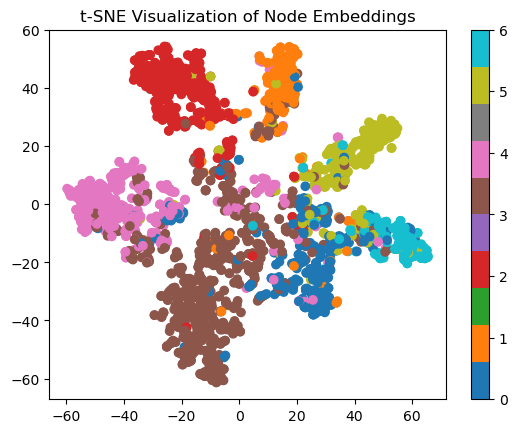

In [18]:
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize embeddings, color by node labels
labels = data.y.cpu().numpy()
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10')
plt.title("t-SNE Visualization of Node Embeddings")
plt.colorbar()
plt.show()


In [20]:
from torch_geometric.datasets import Planetoid

cora_dataset = Planetoid(root='data/Cora', name='Cora')
citeseer_dataset = Planetoid(root='data/Citeseer', name='Citeseer')
cora_data = cora_dataset[0]
citeseer_data = citeseer_dataset[0]


Processing...
Done!
Processing...
Done!


In [22]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [24]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [26]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, data, lr=0.005, wd=5e-4, epochs=200):
    model = model.to(device)
    data = data.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc = 0
    best_test_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        pred = out.argmax(dim=1)
        train_acc = int((pred[data.train_mask] == data.y[data.train_mask]).sum()) / int(data.train_mask.sum())
        val_acc = int((pred[data.val_mask] == data.y[data.val_mask]).sum()) / int(data.val_mask.sum())
        test_acc = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

    return best_val_acc, best_test_acc

# Example of running GCN and GAT on Cora
gcn_model_cora = GCN(in_channels=cora_dataset.num_node_features, hidden_channels=16, out_channels=cora_dataset.num_classes)
gat_model_cora = GAT(in_channels=cora_dataset.num_node_features, hidden_channels=8, out_channels=cora_dataset.num_classes, heads=8)

gcn_val_acc_cora, gcn_test_acc_cora = train(gcn_model_cora, cora_data)
gat_val_acc_cora, gat_test_acc_cora = train(gat_model_cora, cora_data)

print("Cora - GCN:", gcn_test_acc_cora, "GAT:", gat_test_acc_cora)

# Repeat for Citeseer
gcn_model_citeseer = GCN(in_channels=citeseer_dataset.num_node_features, hidden_channels=16, out_channels=citeseer_dataset.num_classes)
gat_model_citeseer = GAT(in_channels=citeseer_dataset.num_node_features, hidden_channels=8, out_channels=citeseer_dataset.num_classes, heads=8)

gcn_val_acc_citeseer, gcn_test_acc_citeseer = train(gcn_model_citeseer, citeseer_data)
gat_val_acc_citeseer, gat_test_acc_citeseer = train(gat_model_citeseer, citeseer_data)

print("Citeseer - GCN:", gcn_test_acc_citeseer, "GAT:", gat_test_acc_citeseer)


Cora - GCN: 0.722 GAT: 0.636
Citeseer - GCN: 0.58 GAT: 0.513


In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_classwise(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1).cpu().numpy()
    labels = data.y.cpu().numpy()
    cm = confusion_matrix(labels[data.test_mask.cpu().numpy()],
                          pred[data.test_mask.cpu().numpy()])
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    return per_class_acc

# Example usage after training:
gcn_class_acc_cora = evaluate_classwise(gcn_model_cora, cora_data)
gat_class_acc_cora = evaluate_classwise(gat_model_cora, cora_data)

print("GCN Cora class-wise accuracy:", gcn_class_acc_cora)
print("GAT Cora class-wise accuracy:", gat_class_acc_cora)


GCN Cora class-wise accuracy: [0.76923077 0.82417582 0.9375     0.7492163  0.83221477 0.73786408
 0.859375  ]
GAT Cora class-wise accuracy: [0.72307692 0.85714286 0.92361111 0.71786834 0.84563758 0.76699029
 0.859375  ]


In [36]:
model.eval()
with torch.no_grad():
    # Forward pass through GATConv layer individually
    x = cora_data.x.to(device)
    edge_index = cora_data.edge_index.to(device)

    # Since our model consists of two GATConv layers (conv1 and conv2),
    # we can run them step-by-step to extract intermediate attention weights:
    out, (edge_index_out, alpha) = model.conv1(x, edge_index, return_attention_weights=True)


In [38]:
attention_weights_cora = alpha.cpu().numpy()
print("Attention Weights Shape:", attention_weights_cora.shape)
print("Mean Attention Weight:", attention_weights_cora.mean())
print("Std Attention Weight:", attention_weights_cora.std())


Attention Weights Shape: (13264, 8)
Mean Attention Weight: 0.20416164
Std Attention Weight: 0.12834816


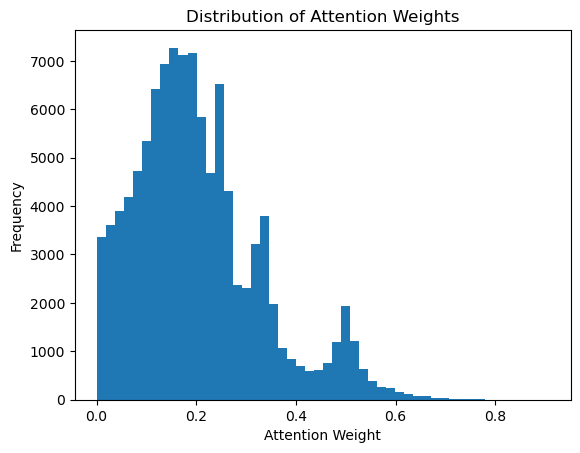

In [40]:
import matplotlib.pyplot as plt

plt.hist(attention_weights_cora.flatten(), bins=50)
plt.title("Distribution of Attention Weights")
plt.xlabel("Attention Weight")
plt.ylabel("Frequency")
plt.show()


In [42]:
row, col = edge_index_out.cpu().numpy()
node_id = 0
mask = (row == node_id) | (col == node_id)
node_attention = attention_weights_cora[mask]
print(f"Node {node_id} Attention Weights:", node_attention)


Node 0 Attention Weights: [[0.22886962 0.2869154  0.24334598 0.25088936 0.24323064 0.24580239
  0.23687439 0.21634662]
 [0.22702275 0.32402518 0.2559602  0.20964384 0.2666545  0.23345639
  0.22569184 0.2845655 ]
 [0.30160898 0.16214196 0.24662164 0.35447705 0.23786357 0.26915792
  0.2990141  0.14992459]
 [0.21316925 0.23892483 0.25922126 0.21013018 0.2622477  0.24946648
  0.2219732  0.4196417 ]
 [0.16951641 0.17959166 0.20310797 0.16086842 0.20470801 0.2008684
  0.18314965 0.30852044]
 [0.22460593 0.23866847 0.2534308  0.16690996 0.2543236  0.25015476
  0.23523915 0.34238777]
 [0.24249868 0.22691739 0.25407216 0.18498972 0.25225133 0.25158337
  0.23841968 0.3491633 ]]


Cora - GCN: Val Acc: 0.79 Test Acc: 0.796
Cora - GAT: Val Acc: 0.796 Test Acc: 0.804


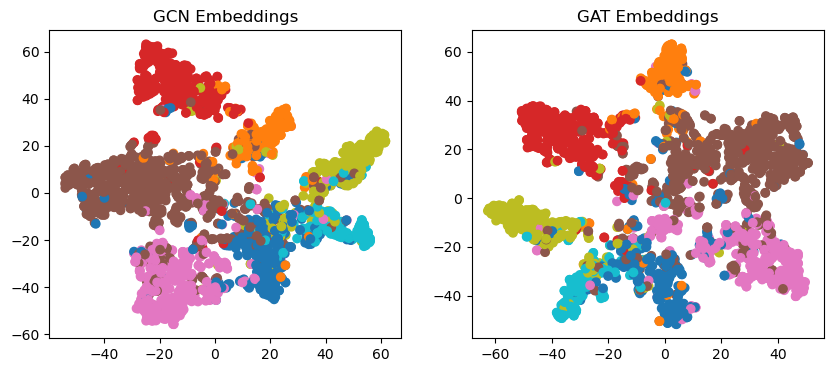

In [50]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

###################################
# Set up device and load dataset
###################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cora_dataset = Planetoid(root='data/Cora', name='Cora')
cora_data = cora_dataset[0].to(device)

###################################
# Define GCN model
###################################
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

###################################
# Define GAT model
###################################
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, _ = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, _ = self.conv2(x, edge_index, return_attention_weights=True)
        return x

###################################
# Training function
###################################
def train(model, data, lr=0.005, wd=5e-4, epochs=200):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc = 0
    best_test_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_acc = int((pred[data.train_mask] == data.y[data.train_mask]).sum()) / int(data.train_mask.sum())
        val_acc = int((pred[data.val_mask] == data.y[data.val_mask]).sum()) / int(data.val_mask.sum())
        test_acc = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

    return model, best_val_acc, best_test_acc

###################################
# Initialize and train models
###################################
model_gcn_cora = GCN(in_channels=cora_dataset.num_node_features,
                     hidden_channels=16,
                     out_channels=cora_dataset.num_classes)

model_gat_cora = GAT(in_channels=cora_dataset.num_node_features,
                     hidden_channels=8,
                     out_channels=cora_dataset.num_classes,
                     heads=8)

model_gcn_cora, gcn_val_acc_cora, gcn_test_acc_cora = train(model_gcn_cora, cora_data)
model_gat_cora, gat_val_acc_cora, gat_test_acc_cora = train(model_gat_cora, cora_data)

print("Cora - GCN: Val Acc:", gcn_val_acc_cora, "Test Acc:", gcn_test_acc_cora)
print("Cora - GAT: Val Acc:", gat_val_acc_cora, "Test Acc:", gat_test_acc_cora)

###################################
# Extract embeddings and visualize
###################################
model_gcn_cora.eval()
model_gat_cora.eval()

with torch.no_grad():
    embeddings_gcn = model_gcn_cora(cora_data.x, cora_data.edge_index).cpu().numpy()
    embeddings_gat = model_gat_cora(cora_data.x, cora_data.edge_index).cpu().numpy()

labels = cora_data.y.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
emb_gcn_2d = tsne.fit_transform(embeddings_gcn)
emb_gat_2d = tsne.fit_transform(embeddings_gat)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(emb_gcn_2d[:,0], emb_gcn_2d[:,1], c=labels, cmap='tab10')
plt.title("GCN Embeddings")

plt.subplot(1,2,2)
plt.scatter(emb_gat_2d[:,0], emb_gat_2d[:,1], c=labels, cmap='tab10')
plt.title("GAT Embeddings")

plt.show()


C:\Users\visha\AppData\Local\Temp\ipykernel_21304\3286643482.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


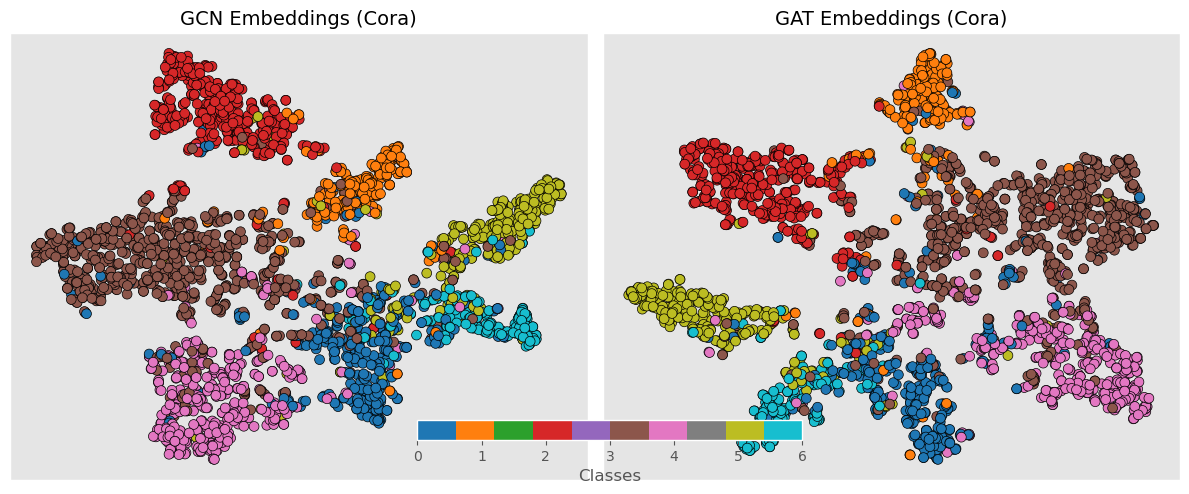

In [58]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Use a built-in matplotlib style
plt.style.use('ggplot')

model_gcn_cora.eval()
model_gat_cora.eval()

with torch.no_grad():
    embeddings_gcn = model_gcn_cora(cora_data.x, cora_data.edge_index).cpu().numpy()
    embeddings_gat = model_gat_cora(cora_data.x, cora_data.edge_index).cpu().numpy()

labels = cora_data.y.cpu().numpy()

# Run t-SNE separately on GCN and GAT embeddings
tsne = TSNE(n_components=2, random_state=42)
emb_gcn_2d = tsne.fit_transform(embeddings_gcn)
emb_gat_2d = tsne.fit_transform(embeddings_gat)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot GCN embeddings
scatter_gcn = axes[0].scatter(
    emb_gcn_2d[:,0], 
    emb_gcn_2d[:,1], 
    c=labels, 
    cmap='tab10', 
    s=50, 
    edgecolors='black', 
    linewidths=0.5
)
axes[0].set_title("GCN Embeddings (Cora)", fontsize=14)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot GAT embeddings
scatter_gat = axes[1].scatter(
    emb_gat_2d[:,0], 
    emb_gat_2d[:,1], 
    c=labels, 
    cmap='tab10', 
    s=50, 
    edgecolors='black', 
    linewidths=0.5
)
axes[1].set_title("GAT Embeddings (Cora)", fontsize=14)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Optional: Add a colorbar to understand class-color mapping
cbar = fig.colorbar(scatter_gcn, ax=axes, orientation='horizontal', fraction=0.05, pad=0.2)
cbar.set_label('Classes')

plt.tight_layout()
plt.show()


Citeseer - GCN: Val Acc: 0.694 Test Acc: 0.673
Citeseer - GAT: Val Acc: 0.69 Test Acc: 0.68


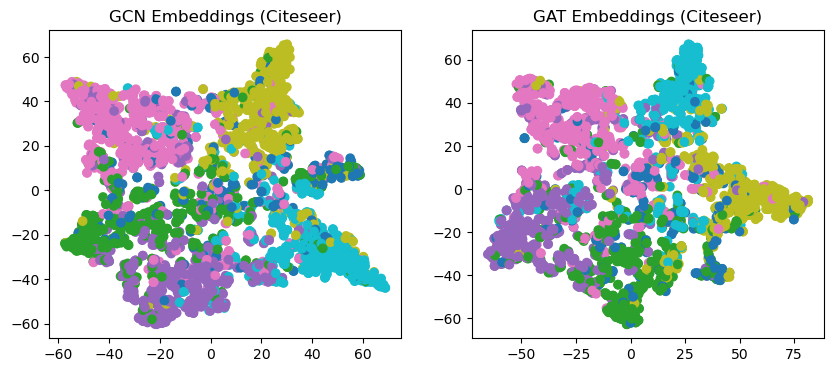

In [52]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

###################################
# Set up device and load dataset
###################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
citeseer_dataset = Planetoid(root='data/Citeseer', name='Citeseer')
citeseer_data = citeseer_dataset[0].to(device)

###################################
# Define GCN model
###################################
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

###################################
# Define GAT model
###################################
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, _ = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x, _ = self.conv2(x, edge_index, return_attention_weights=True)
        return x

###################################
# Training function
###################################
def train(model, data, lr=0.005, wd=5e-4, epochs=200):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc = 0
    best_test_acc = 0
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_acc = int((pred[data.train_mask] == data.y[data.train_mask]).sum()) / int(data.train_mask.sum())
        val_acc = int((pred[data.val_mask] == data.y[data.val_mask]).sum()) / int(data.val_mask.sum())
        test_acc = int((pred[data.test_mask] == data.y[data.test_mask]).sum()) / int(data.test_mask.sum())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

    return model, best_val_acc, best_test_acc

###################################
# Initialize and train models
###################################
model_gcn_citeseer = GCN(in_channels=citeseer_dataset.num_node_features,
                         hidden_channels=16,
                         out_channels=citeseer_dataset.num_classes)

model_gat_citeseer = GAT(in_channels=citeseer_dataset.num_node_features,
                         hidden_channels=8,
                         out_channels=citeseer_dataset.num_classes,
                         heads=8)

model_gcn_citeseer, gcn_val_acc_citeseer, gcn_test_acc_citeseer = train(model_gcn_citeseer, citeseer_data)
model_gat_citeseer, gat_val_acc_citeseer, gat_test_acc_citeseer = train(model_gat_citeseer, citeseer_data)

print("Citeseer - GCN: Val Acc:", gcn_val_acc_citeseer, "Test Acc:", gcn_test_acc_citeseer)
print("Citeseer - GAT: Val Acc:", gat_val_acc_citeseer, "Test Acc:", gat_test_acc_citeseer)

###################################
# Extract embeddings and visualize
###################################
model_gcn_citeseer.eval()
model_gat_citeseer.eval()

with torch.no_grad():
    embeddings_gcn = model_gcn_citeseer(citeseer_data.x, citeseer_data.edge_index).cpu().numpy()
    embeddings_gat = model_gat_citeseer(citeseer_data.x, citeseer_data.edge_index).cpu().numpy()

labels = citeseer_data.y.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
emb_gcn_2d = tsne.fit_transform(embeddings_gcn)
emb_gat_2d = tsne.fit_transform(embeddings_gat)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(emb_gcn_2d[:,0], emb_gcn_2d[:,1], c=labels, cmap='tab10')
plt.title("GCN Embeddings (Citeseer)")

plt.subplot(1,2,2)
plt.scatter(emb_gat_2d[:,0], emb_gat_2d[:,1], c=labels, cmap='tab10')
plt.title("GAT Embeddings (Citeseer)")

plt.show()


C:\Users\visha\AppData\Local\Temp\ipykernel_21304\1787315351.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


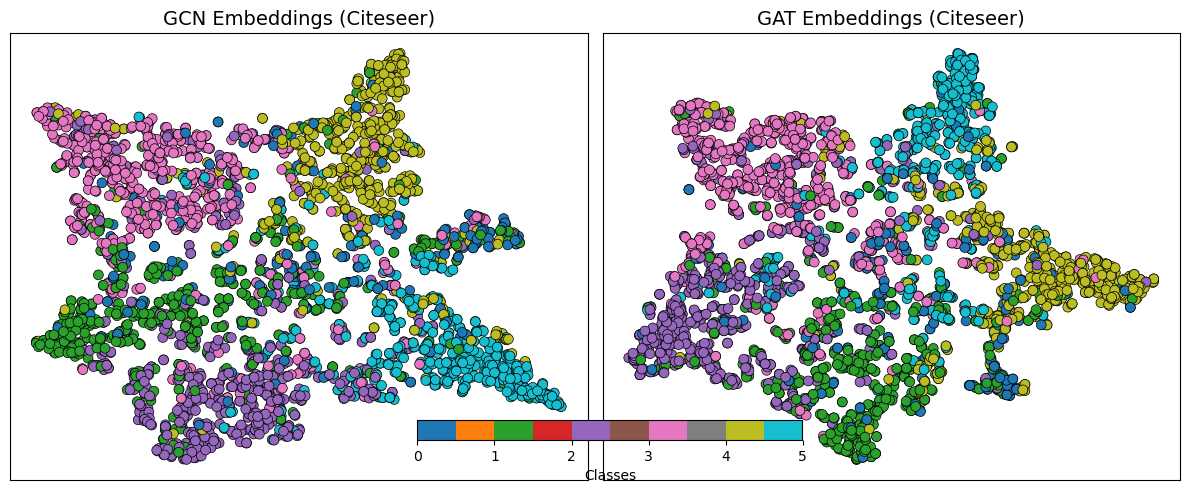

In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply a clean style
#plt.style.use('seaborn-whitegrid')

model_gcn_citeseer.eval()
model_gat_citeseer.eval()

with torch.no_grad():
    embeddings_gcn = model_gcn_citeseer(citeseer_data.x, citeseer_data.edge_index).cpu().numpy()
    embeddings_gat = model_gat_citeseer(citeseer_data.x, citeseer_data.edge_index).cpu().numpy()

labels = citeseer_data.y.cpu().numpy()

# Run t-SNE separately on GCN and GAT embeddings
tsne = TSNE(n_components=2, random_state=42)
emb_gcn_2d = tsne.fit_transform(embeddings_gcn)
emb_gat_2d = tsne.fit_transform(embeddings_gat)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot GCN embeddings
scatter_gcn = axes[0].scatter(
    emb_gcn_2d[:,0], 
    emb_gcn_2d[:,1], 
    c=labels, 
    cmap='tab10', 
    s=50, 
    edgecolors='black', 
    linewidths=0.5
)
axes[0].set_title("GCN Embeddings (Citeseer)", fontsize=14)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Plot GAT embeddings
scatter_gat = axes[1].scatter(
    emb_gat_2d[:,0], 
    emb_gat_2d[:,1], 
    c=labels, 
    cmap='tab10', 
    s=50, 
    edgecolors='black', 
    linewidths=0.5
)
axes[1].set_title("GAT Embeddings (Citeseer)", fontsize=14)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Optional: Add colorbar to understand class-color mapping
# Note: tab10 has 10 distinct colors, ensure number of classes ≤ 10 or adjust cmap
cbar = fig.colorbar(scatter_gat, ax=axes, orientation='horizontal', fraction=0.05, pad=0.2)
cbar.set_label('Classes')

plt.tight_layout()
plt.show()
